## Welcome!

This notebook will allow for the detection of modal filters, rat runs, and analysis of neighbourhood accessiablity within a single notebook. The output of this code is a set of neighbourhoods scored on their plausiablity to be a "Low Traffic Neighbourhood", which is written to a geopackage. To run this code you will need the OS Open Roads dataset available on the OS website: https://osdatahub.os.uk/downloads/open/OpenRoads

### General set up
Import libraries, set location etc.

In [1]:
### set up python
## Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import statistics
from shapely.ops import unary_union
import random
import overpy
import os 
import math
from itertools import count
from collections import Counter
from sklearn.cluster import KMeans
#from osmnx._errors import InsufficientResponseError
from owslib.wms import WebMapService
from rasterio.mask import mask as rio_mask  
from rasterio.features import shapes
from shapely.geometry import shape, mapping
from rasterio.io import MemoryFile
import numpy as np
from shapely.ops import unary_union
import warnings
from shapely.errors import ShapelyDeprecationWarning



## Mute warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=ShapelyDeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)



## Update settings
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )



## Read in place names


In [ ]:
# Define the path to your text file
file_path = r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\plots.txt'

# Initialize an empty list to store the lines
places = []

# Open the file and read each line
with open(file_path, 'r') as file:
    for line in file:
        # Strip the newline character and any surrounding whitespace
        place = line.strip()
        # Append the line to the list
        places.append(place)

# Print the list of places
print("List of places read from test.txt:")
for place in places:
    print(place)


List of places read from test.txt:
City of Chester, United Kingdom


## Set iterations parameter

In [13]:
iterations = 1000

### Read in OS Roads


In [5]:
def get_OS_roads():
        """
        Reads in OS Open Road data from a GeoPackage file.

        Returns:
        os_open_roads (GeoDataFrame): A GeoDataFrame containing road data.
        """
        os_open_roads = gpd.read_file(r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\oproad_gpkg_gb\Data\oproad_roads_only.gpkg")
        return os_open_roads

os_open_roads = get_OS_roads()

C:\Users\b8008458\AppData\Local\Temp\ipykernel_37268\3225741462.py:240: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)


No data elements found for the specified location/tags.
No railway data found for 'light_rail'.
No railway data found for 'narrow_gauge'.
No railway data found for 'subway'.
No railway data found for 'tram'.
No data elements found for the specified location/tags.


C:\Users\b8008458\AppData\Local\Temp\ipykernel_37268\3225741462.py:719: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
C:\Users\b8008458\AppData\Local\Temp\ipykernel_37268\3225741462.py:829: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  neighbourhoods = filter_neighbourhoods_by_roads(neighbourhoods, os_open_roads_clip, 'geometry')
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPytho

No path found between 8300557 and 7761331. Skipping...
No path found between 8300557 and 7761328. Skipping...
No path found between 10010638 and 7761331. Skipping...
No path found between 10010638 and 7761328. Skipping...
No path found between 8300561 and 7761331. Skipping...
No path found between 8300561 and 7761328. Skipping...
No path found between 8300562 and 7761328. Skipping...
No path found between 8300563 and 7761331. Skipping...
No path found between 8300563 and 7761328. Skipping...
No path found between 8300569 and 7761331. Skipping...
No path found between 8300569 and 7761328. Skipping...
No path found between 8300576 and 7761331. Skipping...
No path found between 8300576 and 7761328. Skipping...
No path found between 9095200 and 7761331. Skipping...
No path found between 9095200 and 7761328. Skipping...
No path found between 8300578 and 7761328. Skipping...
No path found between 8300578 and 7761331. Skipping...
No path found between 9095201 and 7761331. Skipping...
No path 

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\b8008

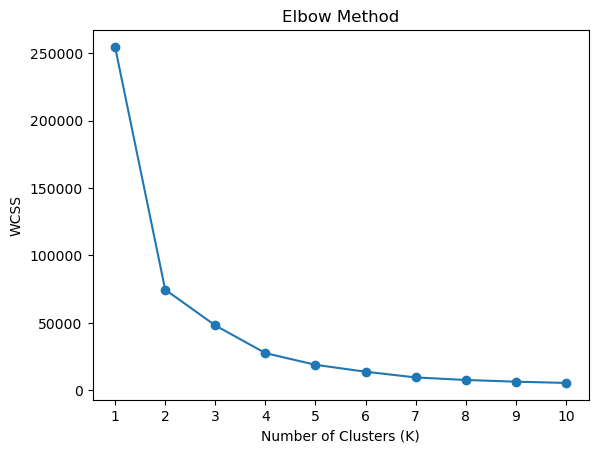

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, va

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [6]:
for place in places:

    # get boundary
    def set_location_boundary(place):
        """
        Sets up the location boundary by geocoding the given place and buffering it.

        Parameters:
        place (str): The name or address of the place to geocode.

        Returns:
        geopandas.GeoDataFrame: The buffered boundary of the location.
        """
        # Set location and get boundary
        boundary = ox.geocode_to_gdf(place)
        boundary = boundary.to_crs('EPSG:27700')

        # Buffer boundary to ensure clips include riverlines which may act as borders between geographies
        boundary_buffered = boundary.buffer(50)

        return boundary_buffered, boundary

    boundary_buffered, boundary = set_location_boundary(place)




    """
    This code retrieves street nodes and edges for walking and driving from OpenStreetMap within our area boundary, and loads the OS Open Roads network dataset.

    Functions:
    - get_street_networks: Retrieves street networks for all, walking, and driving modes within the specified boundary.
    """

    def get_OSM_street_networks(boundary_buffered):
        """
        Retrieves street networks for all, walking, and driving modes within the specified boundary.

        Parameters:
        - boundary_buffered: A GeoDataFrame representing the boundary of the area of interest.

        Returns:
        - all_edges: A GeoDataFrame containing the edges (streets) of the entire street network.
        - all_nodes: A GeoDataFrame containing the nodes (intersections) of the entire street network.
        - walk_edges: A GeoDataFrame containing the edges (streets) of the walking street network.
        - walk_nodes: A GeoDataFrame containing the nodes (intersections) of the walking street network.
        - drive_edges: A GeoDataFrame containing the edges (streets) of the driving street network.
        - drive_nodes: A GeoDataFrame containing the nodes (intersections) of the driving street network.
        - common_nodes_gdf: A GeoDataFrame containing the common nodes between the driving and walking street networks.
        """

        # Reset boundary_buffered crs for passing to OSM
        boundary_buffered_4326 = boundary_buffered.to_crs('4326')

        # Get street networks
        all_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='all', simplify=False)
        walk_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='walk', simplify=True)
        drive_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='drive', simplify=False)

        all_edges = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)
        all_nodes = ox.graph_to_gdfs(all_streets, nodes=True, edges=False)

        walk_edges = ox.graph_to_gdfs(walk_streets, nodes=False, edges=True)
        walk_nodes = ox.graph_to_gdfs(walk_streets, nodes=True, edges=False)

        drive_edges = ox.graph_to_gdfs(drive_streets, nodes=False, edges=True)
        drive_nodes = ox.graph_to_gdfs(drive_streets, nodes=True, edges=False)

        # Find the common nodes between networks
        # This ensures that shortest paths between points should always be able to be calculated
        common_nodes = drive_nodes.merge(walk_nodes, on='osmid', suffixes=('_drive', '_walk'))
        common_nodes_gdf = gpd.GeoDataFrame(common_nodes, geometry='geometry_drive')

        return all_edges, all_nodes, walk_edges, walk_nodes, drive_edges, drive_nodes, common_nodes_gdf, all_streets, walk_streets, drive_streets


    # get street networks
    all_edges, all_nodes, walk_edges, walk_nodes, drive_edges, drive_nodes, common_nodes_gdf, all_streets, walk_streets, drive_streets = get_OSM_street_networks(boundary_buffered)
    #os_open_roads = get_OS_roads()  this is now got at the start of the code to avoid re-reading


    def retrieve_osm_features(polygon, tags):
        """
        Retrieves OpenStreetMap features based on the specified polygon and tags.

        Args:
            polygon (Polygon): The polygon to retrieve features within.
            tags (dict): The tags to filter the features.

        Returns:
            GeoDataFrame: The retrieved OpenStreetMap features.
        """
        try:
            features = ox.features_from_polygon(polygon=polygon, tags=tags)
        except Exception as e:
            error_message = str(e)
            if "There are no data elements in the server response" in error_message:
                print("No data elements found for the specified location/tags.")
                features = gpd.GeoDataFrame()  # Create an empty GeoDataFrame
            else:
                # Handle other exceptions here if needed
                print("An error occurred:", error_message)
                features = None
        return features


    def get_railways(place):
        """
        This retrievies and processes OpenStreetMap (OSM) railways data for a specified place.

        Args:
            place (str): The name of the place to retrieve OSM features for.

        Returns:
            railways (geopandas.GeoDataFrame): A GeoDataFrame containing the railways within the specified place.
        """

        # for unknown reasons, using rail = ox.graph_from_place(place, custom_filter='["railway"]')
        # doesn't ALWAYS retrive the full rail network, hence why multiple lines are used to achive the same result

        # Define railway types to retrieve
        railway_types = ["", "rail", "light_rail", "narrow_gauge", "subway", "tram"]

        # Initialize an empty graph
        combined_railways = nx.MultiDiGraph()

        for railway_type in railway_types:
            try:
                # Fetch the railway network for the specified type
                network = ox.graph_from_place(place, simplify=False, custom_filter=f'["railway"~"{railway_type}"]')

                # Ensure the fetched network is a MultiDiGraph
                if not isinstance(network, nx.MultiDiGraph):
                    network = nx.MultiDiGraph(network)

            except Exception as e:
                print(f"No railway data found for '{railway_type}'.")
                network = nx.MultiDiGraph()

            # Compose the networks
            combined_railways = nx.compose(combined_railways, network)

        # Convert to GeoDataFrame
        railways = ox.graph_to_gdfs(combined_railways, nodes=False, edges=True)

        # Drop any other railway types that aren't needed
        railways = railways.loc[(~railways["railway"].isin(["tunnel", "abandoned", "razed", "disused", "funicular", "monorail", "miniature"]))]

        # Drop rows where any of the specified columns have values "True" or "yes"
        columns_to_check = ['tunnel', 'abandoned', 'razed', 'disused', 'funicular', 'monorail', 'miniature']
        railways = railways.loc[~railways[railways.columns.intersection(columns_to_check)].isin(['True', 'yes']).any(axis=1)]

        # Set railways CRS
        railways = railways.to_crs('EPSG:27700')

        return railways



    
    ## get urban footprints from GUF

    def get_guf(place):
        """
        Retrieves a clipped GeoDataFrame of GUF urban areas within a specified place boundary.

        Parameters:
        - place (str): The name or address of the place to retrieve urban areas for.

        Returns:
        - gdf_clipped (GeoDataFrame): A GeoDataFrame containing the clipped urban areas within the specified place boundary.
        """

        # Step 1: Access the WMS Service
        wms_url = 'https://geoservice.dlr.de/eoc/land/wms?GUF04_DLR_v1_Mosaic'
        wms = WebMapService(wms_url, version='1.1.1')

        # Step 2: Identify the Layer with ID 102. This is the Global Urban Footprint layer GUF
        for layer_name, layer in wms.contents.items():
            if '102' in layer_name:
                print(f"Layer ID 102 found: {layer_name}")

        # Assuming 'GUF04_DLR_v1_Mosaic' is the layer with ID 102
        layer = 'GUF04_DLR_v1_Mosaic'  # Replace with the actual layer name if different

        # Step 3: Get the polygon boundary using osmnx
        boundary_gdf = ox.geocode_to_gdf(place)
        boundary = boundary_gdf.to_crs('EPSG:27700')
        # buffer boundary to ensure clips include riverlines which may act as borders between geographies
        boundary_buffered = boundary.buffer(100)
        boundary_buffered = boundary_buffered.to_crs('EPSG:4326')
        boundary_polygon = boundary_gdf.geometry[0]
        wms_boundary = boundary_buffered.geometry[0]

        # Convert the polygon to a bounding box
        minx, miny, maxx, maxy = wms_boundary.bounds

        # Step 4: Request the data from WMS using the bounding box
        width = 1024
        height = 1024
        response = wms.getmap(
            layers=[layer],
            srs='EPSG:4326',
            bbox=(minx, miny, maxx, maxy),
            size=(width, height),
            format='image/geotiff'
        )

        # Step 5: Load the Raster Data into Rasterio
        with MemoryFile(response.read()) as memfile:
            with memfile.open() as src:
                image = src.read(1)  # Read the first band
                transform = src.transform
                crs = src.crs

                # Clip the raster data to the polygon
                out_image, out_transform = rio_mask(src, [mapping(wms_boundary)], crop=True)  # Use renamed mask function
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform,
                                "crs": crs})

        # Step 6: Convert Raster to Vector
        mask_arr = (out_image[0] != 0).astype(np.uint8)  # Assuming non-zero values are urban areas

        shapes_gen = shapes(mask_arr, mask=mask_arr, transform=out_transform)

        polygons = []
        for geom, value in shapes_gen:
            polygons.append(shape(geom))

        # Create a GeoDataFrame from the polygons
        gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

        # Step 7: Create Buffers Around Urban Areas
        buffer_distance = 100  # Buffer distance in meters (adjust as needed)
        gdf_buffered = gdf.copy()
        gdf_buffered['geometry'] = gdf['geometry'].buffer(buffer_distance)

        # Step 8: Clip the GeoDataFrame to the boundary of the place
        gdf_clipped = gpd.clip(gdf, boundary_gdf)

        return gdf_clipped


    guf = get_guf(place)




    ## get residential areas

    def get_residential_areas(polygon):
        polygon = polygon.to_crs('EPSG:4326')
        # Retrieve features from OpenStreetMap
        features = ox.features_from_polygon(polygon.iloc[0], tags={'landuse': 'residential'})
        
        # Convert features to a GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(features)
        gdf = gdf.set_crs('EPSG:4326')
        
        return gdf


    residential_areas = get_residential_areas(boundary_buffered)
        
        

    ## join urban foot prints and residential areas
    # this is to create a single polygon of where neighbourhoods can be found within

    def join_geodataframes(gdf1, gdf2):
        # Ensure both GeoDataFrames have the exact same CRS
        target_crs = 'EPSG:4326'  # WGS 84
        gdf1 = gdf1.to_crs(target_crs)
        gdf2 = gdf2.to_crs(target_crs)
        
        # Concatenate GeoDataFrames
        joined_gdf = pd.concat([gdf1, gdf2], ignore_index=True)
        
        return gpd.GeoDataFrame(joined_gdf, crs=target_crs)


    guf_residential_gdf = join_geodataframes(guf, residential_areas)


    ## create a small buffer to ensure all areas a captured correctly

    def buffer_geometries_in_meters(gdf, distance):
        # Define the World Mercator projected CRS
        projected_crs = 'EPSG:3395'  # World Mercator

        # Project to the new CRS
        gdf_projected = gdf.to_crs(projected_crs)
        
        # Buffer the geometries
        gdf_projected['geometry'] = gdf_projected['geometry'].buffer(distance)
        
        # Reproject back to the original CRS
        gdf_buffered = gdf_projected.to_crs(gdf.crs)
        
        return gdf_buffered


    guf_residential_gdf = buffer_geometries_in_meters(guf_residential_gdf, 100)  # Buffer by 100 meters


    ## union into one gdf

    def unary_union_polygons(gdf):
        # Combine all geometries into a single geometry
        unified_geometry = unary_union(gdf['geometry'])
        
        # Create a new GeoDataFrame with a single row containing the unified geometry
        combined_gdf = gpd.GeoDataFrame({'geometry': [unified_geometry]}, crs=gdf.crs)
        
        return combined_gdf


    guf_residential_gdf = unary_union_polygons(guf_residential_gdf)

    # set to BNG
    guf_residential_gdf = guf_residential_gdf.to_crs("27700")

    # Function to remove holes from neighbourhoods
    def remove_holes(polygon):
        if polygon.geom_type == 'Polygon':
            return Polygon(polygon.exterior)
        else:
            return polygon

    # remove holes from urban footprint
    guf_residential_gdf['geometry'] = guf_residential_gdf['geometry'].apply(remove_holes)







    def get_rivers(boundary_buffered):
        """
        Retrieves river features within a given boundary.

        Args:
            boundary_buffered (GeoDataFrame): A GeoDataFrame representing the buffered boundary.

        Returns:
            GeoDataFrame: A GeoDataFrame containing the river features within the boundary.
        """
        # Ensure the boundary is in the correct CRS for the query
        boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

        # Check the content of boundary_buffered to ensure it's not empty and correctly transformed
        if boundary_buffered.empty:
            raise ValueError("The provided boundary is empty.")

        # Define the tags for waterways
        tags = {"waterway": ["river", "rapids"]}

        try:
            # Fetch features from OSM using the boundary geometry
            polygon = boundary_buffered.geometry.iloc[0]
            rivers = ox.features_from_polygon(polygon=polygon, tags=tags)

            # Dropping rows where 'tunnel' is equal to 'culvert'
            if 'tunnel' in rivers.columns:
                rivers = rivers[rivers['tunnel'] != 'culvert']

            # Convert the CRS back to the desired one
            rivers = rivers.to_crs('EPSG:27700')

            # Set the geometry column explicitly
            rivers = rivers.set_geometry('geometry')

            return rivers

        except InsufficientResponseError:
            print("No data elements found for the given boundary and tags.")
            empty_geometry = {'geometry': [LineString()]}
            rivers = gpd.GeoDataFrame(empty_geometry, crs='EPSG:27700')
            return rivers # Return an empty GeoDataFrame if no data found



    def get_landuse(boundary_buffered):
        """
        Retrieves the landuse features based on the specified boundary.

        Args:
            boundary_buffered (GeoDataFrame): The buffered boundary polygon.

        Returns:
            GeoDataFrame: The landuse features.
        """
        # reset boundary crs to allow for features to be found
        boundary_buffered = boundary_buffered.to_crs('EPSG:4326')
        # Define tags
        tags = {"landuse": ["industrial", "railway", "brownfield", "commercial", "farmland", "meadow"]}
        # Use ox.features_from_polygon to find features matching the specified tags
        landuse = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
        # set/reset crs
        landuse = landuse.to_crs('27700')

        ## get unsuitable "nature" types
        # Define tags
        tags = {"natural": ["wood", "water", "scrub", "coastline", "beach"]}
        # Use ox.features_from_polygon to find features matching the specified tags
        nature = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
        # set/reset crs
        nature = nature.to_crs('27700')

        ## get unsuitable "lesiure" types. This is mainly for golfcourses
        # Define tags
        tags = {"leisure": ["golf_course", "track", "park"]}
        # Use ox.features_from_polygon to find features matching the specified tags
        leisure = ox.features_from_polygon(polygon=boundary_buffered.iloc[0], tags=tags)
        # set/reset crs
        leisure = leisure.to_crs('27700')
        # Define the tags for aeroway
        aeroway_tags = {"aeroway": ["aerodrome"]}
        # Use the function to retrieve aeroway features
        aeroway = retrieve_osm_features(polygon=boundary_buffered.iloc[0], tags=aeroway_tags)
        # Check if any features were retrieved
        if aeroway is not None:
            if not aeroway.empty:
                # set/reset crs
                aeroway = aeroway.to_crs('27700')

        # concat
        landuse = pd.concat([landuse, nature, leisure, aeroway])

        ## resest boundary crs
        boundary_buffered = boundary_buffered.to_crs('EPSG:27700')

        return landuse


    def get_bus_routes(boundary_buffered):
            """
            Retrieves bus routes from OSM/NAPTAN within a given boundary.

            Args:
                    boundary_buffered (GeoDataFrame): A GeoDataFrame representing the boundary.

            Returns:
                    bus_routes (GeoDataFrame): A GeoDataFrame containing the bus routes.

            Raises:
                    Exception: If there is an error fetching the data from the Overpass API.
            """
            # reset boundary crs to allow for features to be found
            boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

            # Calculate the bounding box for XML query
            bounding_box = boundary_buffered.bounds

            # Extract the minimum and maximum coordinates
            minx = bounding_box['minx'].min()
            miny = bounding_box['miny'].min()
            maxx = bounding_box['maxx'].max()
            maxy = bounding_box['maxy'].max()

            # Create a list of four elements representing the bounding box
            bbox = [minx, miny, maxx, maxy]

            # reset boundary_buffer crs
            boundary_buffered = boundary_buffered.to_crs('27700')

            # Define the Overpass API endpoint
            overpass_url = "https://overpass-api.de/api/interpreter"

            # Define the XML query
            xml_query = f"""
            <osm-script output="json" output-config="" timeout="160">
                <union into="_">
                    <query into="_" type="node">
                        <has-kv k="route" modv="" v="bus"/>
                        <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                    </query>
                    <query into="_" type="way">
                        <has-kv k="route" modv="" v="bus"/>
                        <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                    </query>
                    <query into="_" type="relation">
                        <has-kv k="route" modv="" v="bus"/>
                        <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
                    </query>
                </union>
                <print e="" from="_" geometry="full" ids="yes" limit="" mode="body" n="" order="id" s="" w=""/>
                <recurse from="_" into="_" type="down"/>
                <print e="" from="_" geometry="full" ids="yes" limit="" mode="skeleton" n="" order="quadtile" s="" w=""/>
            </osm-script>

            """

            # Initialize lists to store data
            geometries = []
            element_data = []

            # Make the Overpass API request
            response = requests.post(overpass_url, data=xml_query)

            # Check if the request was successful
            if response.status_code == 200:
                    data = response.json()

                    # Access the data from the response
                    for element in data.get("elements", []):
                            if element.get('type') == 'way' and 'geometry' in element:
                                    # Extract geometry coordinates from 'geometry' field
                                    coordinates = [(node['lon'], node['lat']) for node in element['geometry']]
                                    # Create a LineString geometry
                                    line = LineString(coordinates)
                                    geometries.append(line)
                                    element_data.append(element)

                    # Create a GeoDataFrame
                    bus_routes = gpd.GeoDataFrame(element_data, geometry=geometries)

                    # Set CRS
                    bus_routes = bus_routes.set_crs('4326')
                    bus_routes = bus_routes.to_crs('27700')

                    return bus_routes

            else:
                    raise Exception(f"Error fetching data: {response.status_code} - {response.text}")



    def clip_boundaries(os_open_roads, rivers, railways, landuse, bus_routes, boundary_buffered):
        """
        Clips the geospatial data to the boundary_buffered extent.

        Parameters:
        - os_open_roads (GeoDataFrame): lines from OS Open roads.
        - rivers (GeoDataFrame): lines of Rivers.
        - railways (GeoDataFrame): lines of Railways.
        - landuse (GeoDataFrame): Land use polygons.
        - bus_routes (GeoDataFrame): lines of bus routes.
        - boundary_buffered (GeoDataFrame): buffered boundary.

        Returns:
        - clipped versions of input geodataframes, aside from the bufferd boundary.
        """
        os_open_roads_clip = gpd.clip(os_open_roads, boundary_buffered)
        rivers_clip = gpd.clip(rivers, boundary_buffered)
        railways_clip = gpd.clip(railways, boundary_buffered)
        landuse_clip = gpd.clip(landuse, boundary_buffered)
        bus_routes_clip = gpd.clip(bus_routes, boundary_buffered)

        return os_open_roads_clip, rivers_clip, railways_clip, landuse_clip, bus_routes_clip


    def process_bus_routes(bus_routes_clip, buffer_distance):
        """
        Count the number of bus routes per road and remove roads with more than one bus route on them.
        
        Args:
            bus_routes_clip (GeoDataFrame): The input GeoDataFrame containing bus routes.
            buffer_distance (float): The buffer distance to convert roads to polygons, set in meters.
        
        Returns:
            GeoDataFrame: The filtered GeoDataFrame containing roads with less than or equal to one bus route.
        """
        # Create a new GeoDataFrame with the buffered geometries
        bus_routes_buffered = bus_routes_clip.copy()  # Copy the original GeoDataFrame
        bus_routes_buffered['geometry'] = bus_routes_buffered['geometry'].buffer(buffer_distance)

        # count the number of overlapping bus routes
        def count_overlapping_features(gdf):
            """
            Count the number of overlapping features in a GeoDataFrame.
            
            Args:
                gdf (GeoDataFrame): The input GeoDataFrame.
            
            Returns:
                GeoDataFrame: The input GeoDataFrame with an additional column 'Bus_routes_count' indicating the count of overlapping features.
            """
            # Create an empty column to store the count of overlapping features
            gdf['Bus_routes_count'] = 0

            # Iterate through each row in the GeoDataFrame
            for idx, row in gdf.iterrows():
                # Get the geometry of the current row
                geometry = row['geometry']
                
                # Use a spatial filter to find overlapping features
                overlaps = gdf[gdf['geometry'].intersects(geometry)]
                
                # Update the Bus_routes_count column with the count of overlapping features
                gdf.at[idx, 'Bus_routes_count'] = len(overlaps)
            
            return gdf

        # call function
        bus_routes_buffered_with_count = count_overlapping_features(bus_routes_buffered)

        # drop any roads which have less than two bus routes on them
        bus_routes_filtered = bus_routes_buffered_with_count[bus_routes_buffered_with_count['Bus_routes_count'] >= 2]
        
        return bus_routes_filtered



    def filter_OS_boundary_roads(os_open_roads_clip):
        """
        Filter the `os_open_roads_clip` DataFrame to select boundary roads.

        This function filters the `os_open_roads_clip` DataFrame to select roads that are considered "boundary" roads. 
        The selection criteria include roads that have the following attributes:
        - `primary_route` is True
        - `trunk_road` is True
        - `fictitious` is True
        - `road_classification` is 'A Road' or 'B Road'
        - `road_function` is 'Minor Road' or 'Motorway'

        The filtered DataFrame is returned.

        Note: The commented line `(os_open_roads_clip['road_function'] == 'Restricted Local Access Road')` is excluded from the selection.

        Parameters:
        - os_open_roads_clip (DataFrame): A DataFrame containing road data.

        Returns:
        - boundary_roads (DataFrame): A DataFrame containing the filtered boundary roads.

        Example usage:
            # Assuming `os_open_roads_clip` is a DataFrame containing road data
            boundary_roads = filter_boundary_roads(os_open_roads_clip)
        """
        boundary_roads = os_open_roads_clip.loc[((os_open_roads_clip['primary_route'] == 'True') |
                        (os_open_roads_clip['trunk_road'] == 'True') |
                        (os_open_roads_clip['fictitious'] == 'True') |
                        (os_open_roads_clip['road_classification'] == 'A Road') | 
                        (os_open_roads_clip['road_classification'] == 'B Road') | 
                        (os_open_roads_clip['road_function'] == 'Minor Road') |
                        (os_open_roads_clip['road_function'] == 'Motorway') |
                        (os_open_roads_clip['road_function'] == 'Minor Road')  
                        )]
        return boundary_roads



    ## buffering and dissolving functions
    
    def buffer_and_dissolve(input_gdf):
        """
        Buffer and dissolve a GeoDataFrame.
        
        Args:
            input_gdf (GeoDataFrame): The input GeoDataFrame.
        
        Returns:
            GeoDataFrame: The buffered and dissolved GeoDataFrame.
        """
        # Buffer around boundaries
        buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
        buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

        # Dissolve the geometries
        dissolved_geo = buffered_gdf.unary_union

        # Create a new GeoDataFrame with the dissolved geometry
        dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

        # Set the CRS (Coordinate Reference System)
        dissolved_gdf.crs = input_gdf.crs

        return dissolved_gdf


    def dissolve_gdf(input_gdf):
        # dissolve geometries
        dissolved_geo = input_gdf.unary_union
        dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
        dissolved_gdf.crs = input_gdf.crs

        return dissolved_gdf


    def erase_boundary_features(boundary, boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd, guf_residential_gdf):
        """
        Erases boundary features from the given boundary geometry.

        Parameters:
        - boundary: GeoDataFrame representing the boundary geometry
        - boundary_rivers_bd: GeoDataFrame representing the rivers boundary features
        - boundary_roads_bd: GeoDataFrame representing the roads boundary features
        - boundary_rail_bd: GeoDataFrame representing the rail boundary features
        - boundary_landuse_bd: GeoDataFrame representing the landuse boundary features
        - boundary_bus_routes_bd: GeoDataFrame representing the bus routes boundary features

        Returns:
        - erased_boundary_gdf: GeoDataFrame containing the result of the "Erase" operation
        """

        # ensure that neighbourhoods fall only within urban footprint areas
        boundary = gpd.clip(boundary, guf_residential_gdf)

        # Join all boundary features
        boundaries = pd.concat([boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd], ignore_index=True)
        boundary_features = dissolve_gdf(boundaries)

        # Use the `difference` method to perform the "Erase" operation
        erased_boundary = boundary.difference(boundary_features.unary_union)

        # Convert the GeoSeries to a single geometry using unary_union
        erased_boundary = erased_boundary.unary_union

        # Create a new GeoDataFrame with the result of "Erase" operation
        erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

        # Explode multipolygon to polygons
        erased_boundary_gdf = erased_boundary_gdf.explode()

        return erased_boundary_gdf


    def drop_large_or_small_areas(neighbourhoods):
        """
        Drops rows from the 'neighbourhoods' DataFrame where the area is less than 10,000 square units or greater than 5,000,000 square units.

        Parameters:
        - neighbourhoods (DataFrame): The input DataFrame containing neighbourhood data.

        Returns:
        - neighbourhoods (DataFrame): The updated DataFrame with small areas dropped.
        """
        # Calculate area
        neighbourhoods["area"] = neighbourhoods.geometry.area

        # Drop rows where area is less than 10,000 or greater than 5,000,000
        neighbourhoods = neighbourhoods.loc[(neighbourhoods["area"] >= 10000)]
        neighbourhoods = neighbourhoods.loc[(neighbourhoods["area"] <= 5000000)]

        return neighbourhoods


    def filter_neighbourhoods_by_roads(neighbourhoods, os_open_roads_clip, polygon_column_name):
        """
        Count the number of roads within each polygon in a GeoDataFrame and filter the neighbourhoods based on road count and road density.
        
        Args:
            neighbourhoods (GeoDataFrame): GeoDataFrame containing neighbourhood polygons.
            os_open_roads_clip (GeoDataFrame): GeoDataFrame containing road data.
            polygon_column_name (str): Name of the column in neighbourhoods to use for grouping.

        Returns:
            GeoDataFrame: Updated neighbourhoods GeoDataFrame with filtered rows based on road count and road density.
        """
        
        def count_roads_within_polygons(polygons_gdf, roads_gdf, polygon_column_name):
            """
            Count the number of roads within each polygon in a GeoDataFrame.
            
            Args:
                polygons_gdf (GeoDataFrame): GeoDataFrame containing polygons.
                roads_gdf (GeoDataFrame): GeoDataFrame containing roads.
                polygon_column_name (str): Name of the column in polygons_gdf to use for grouping.

            Returns:
                GeoDataFrame: Original polygons GeoDataFrame with a "road_count" column added.
            """
            
            # spatial join
            joined = gpd.sjoin(polygons_gdf, roads_gdf, how='left', op='intersects')
            
            # Group by the polygon column and count the number of roads in each
            road_counts = joined.groupby(polygon_column_name).size().reset_index(name='road_count')
            
            # Merge the road counts back into the polygons GeoDataFrame
            polygons_gdf = polygons_gdf.merge(road_counts, on=polygon_column_name, how='left')

            # Calculate road density (area divided by road_count). It is multiplied by 10000 for ease of understanding the numbers involved with this
            polygons_gdf['road_density'] = (polygons_gdf['road_count'] / polygons_gdf['area'] ) * 10000
            
            return polygons_gdf
        
        neighbourhoods = count_roads_within_polygons(neighbourhoods, os_open_roads_clip, polygon_column_name)

        # Drop rows with road_density below 0.2 or less than 4 roads
        neighbourhoods = neighbourhoods[(neighbourhoods['road_count'] > 2)]
        neighbourhoods = neighbourhoods[(neighbourhoods['road_density'] > 0.2)]
        
        return neighbourhoods


    def remove_holes(polygon):
        """
        Removes holes from a polygon. Mostly for visual reasons.

        Parameters:
        polygon (Polygon): The polygon to remove holes from.

        Returns:
        Polygon: The polygon without holes.
        """
        if polygon.geom_type == 'Polygon':
            return Polygon(polygon.exterior)
        else:
            return polygon

    landuse = get_landuse(boundary_buffered)
    rivers = get_rivers(boundary_buffered)
    railways = get_railways(place)
    landuse = get_landuse(boundary_buffered)
    bus_routes = get_bus_routes(boundary_buffered)
    os_open_roads_clip, rivers_clip, railways_clip, landuse_clip, bus_routes_clip = clip_boundaries(os_open_roads, rivers, railways, landuse, bus_routes, boundary_buffered)
    bus_routes_clip = process_bus_routes(bus_routes_clip, 0.2)
    boundary_roads = filter_OS_boundary_roads(os_open_roads_clip)

    ## buffer and dissolve 
    boundary_roads_bd = buffer_and_dissolve(boundary_roads)
    boundary_rivers_bd = buffer_and_dissolve(rivers_clip)
    boundary_rail_bd = buffer_and_dissolve(railways_clip)
    boundary_landuse_bd = buffer_and_dissolve(landuse_clip)
    boundary_bus_routes_bd = buffer_and_dissolve(bus_routes_clip)

    ## geodataframe cleaning
    erased_boundary_gdf = erase_boundary_features(boundary, boundary_rivers_bd, boundary_roads_bd, boundary_rail_bd, boundary_landuse_bd, boundary_bus_routes_bd, guf_residential_gdf)
    neighbourhoods = erased_boundary_gdf
    neighbourhoods = drop_large_or_small_areas(neighbourhoods)

    neighbourhoods = filter_neighbourhoods_by_roads(neighbourhoods, os_open_roads_clip, 'geometry')

    ## create unique IDs
    # simple number based ID
    neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)

    neighbourhoods['geometry'] = neighbourhoods['geometry'].apply(remove_holes)


    ## filter neighbourhoods to only locations with more than 1 intersection (1 or fewer intersections indicates that all travel modes will be the same)
    # reset neighbourhoods crs
    neighbourhoods = neighbourhoods.to_crs('4326')

    # Spatial join to count points within each neighborhood
    spatial_join = gpd.sjoin(neighbourhoods, common_nodes_gdf, how='left', op='contains')

    # Group by 'ID' and count the points within each neighborhood
    point_counts = spatial_join.groupby('ID').size().reset_index(name='point_count')

    # Filter out neighborhoods with 1 or 0 points
    filtered_neighbourhood_ids = point_counts[point_counts['point_count'] > 1]['ID']

    neighbourhoods= neighbourhoods[neighbourhoods['ID'].isin(filtered_neighbourhood_ids)]



    ## we also need to join the length of the streets within the neighbourhood for further analysis
    # Reset index of neighbourhoods
    neighbourhoods = neighbourhoods.reset_index(drop=True)

    # reset neighbourhoods crs
    neighbourhoods = neighbourhoods.to_crs('27700')

    # Perform a spatial join
    joined_data = gpd.sjoin(os_open_roads_clip, neighbourhoods, how="inner", op="intersects")

    # Group by neighborhood and calculate total road length
    road_lengths = joined_data.groupby('index_right')['length'].sum().reset_index()

    # Merge road_lengths with neighbourhoods and drop 'index_right' column
    neighbourhoods = neighbourhoods.merge(road_lengths, left_index=True, right_on='index_right', how='left').drop(columns=['index_right'])

    # Rename the column
    neighbourhoods.rename(columns={'length': 'road_lengths'}, inplace=True)



    ### find accessiablity

    ## all to all
    def calculate_distance_stats_from_points(points_gdf, network):
        all_pairs_shortest_paths = {}
        points_osmids = points_gdf.index.tolist()  # Assuming the 'osmid' is the index in the GeoDataFrame

        for start_node in points_osmids:
            shortest_paths = {}
            try:
                for end_node in points_osmids:
                    if start_node != end_node:
                        distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                        shortest_paths[end_node] = distance
                all_pairs_shortest_paths[start_node] = shortest_paths
            except nx.NetworkXNoPath:
                # If no path is found, skip adding to all_pairs_shortest_paths
                continue

        distances = [length for paths in all_pairs_shortest_paths.values() for length in paths.values()]

        mean_distance = statistics.mean(distances)
        median_distance = statistics.median(distances)
        min_distance = min(distances)
        max_distance = max(distances)
        distance_range = max_distance - min_distance
        total_distance = sum(distances)

        return {
            "mean_distance": mean_distance,
            "median_distance": median_distance,
            "min_distance": min_distance,
            "max_distance": max_distance,
            "distance_range": distance_range,
            "total_distance": total_distance
        }

    ## processing for all to all 
    results = []

    for index, row in neighbourhoods.iterrows():
        neighbourhood = neighbourhoods.loc[[index]]

        ## get neighbourhood boundary and neighbourhood boundary buffer
        # set crs
        neighbourhood = neighbourhood.to_crs('27700')
        # create a buffer neighbourhood
        neighbourhood_buffer = neighbourhood['geometry'].buffer(15)
        # convert back to a geodataframe (for later on)
        neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)
        # reset crs
        neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


        ## get nodes which can be driven to and walked to within area
        neighbourhood_nodes = gpd.clip(common_nodes_gdf, neighbourhood_buffer)

        ## get length of total edges within the neighbourhood
        edges_within_neighbourhood = gpd.sjoin(all_edges, neighbourhood, how="inner", op="intersects")
        total_length = edges_within_neighbourhood['length'].sum()


        ## calculate neighbourhood distance stats for walking and driving
        walk_stats = calculate_distance_stats_from_points(neighbourhood_nodes, walk_streets)
        drive_stats = calculate_distance_stats_from_points(neighbourhood_nodes, drive_streets)


        ## Add the statistics to the GeoDataFrame
        neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
        neighbourhood['walk_median_distance'] = walk_stats['median_distance']
        neighbourhood['walk_min_distance'] = walk_stats['min_distance']
        neighbourhood['walk_max_distance'] = walk_stats['max_distance']
        neighbourhood['walk_distance_range'] = walk_stats['distance_range']
        neighbourhood['walk_total_distance'] = walk_stats['total_distance']

        neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
        neighbourhood['drive_median_distance'] = drive_stats['median_distance']
        neighbourhood['drive_min_distance'] = drive_stats['min_distance']
        neighbourhood['drive_max_distance'] = drive_stats['max_distance']
        neighbourhood['drive_distance_range'] = drive_stats['distance_range']
        neighbourhood['drive_total_distance'] = drive_stats['total_distance']

        ## Store statistics along with neighborhood ID or other identifying information
        result = {
            'neighbourhood_id': neighbourhood['ID'].iloc[0],  # Assuming you have an ID column
            'walk_mean_distance': walk_stats['mean_distance'],
            'walk_median_distance': walk_stats['median_distance'],
            'walk_total_distance': walk_stats['total_distance'],
            

            'drive_mean_distance': drive_stats['mean_distance'],
            'drive_median_distance': drive_stats['median_distance'],
            'drive_total_distance': drive_stats['total_distance'],

            'total_edge_length': total_length
        }
        results.append(result)

    ## Convert the results to a new dataframe
    results_df = pd.DataFrame(results)


    ## calculate differances

    results_df['mean_distance_diff'] = results_df['walk_mean_distance'] - results_df['drive_mean_distance']
    results_df['median_distance_diff'] = results_df['walk_median_distance'] - results_df['drive_median_distance']
    results_df['total_distance_diff'] = results_df['walk_total_distance'] - results_df['drive_total_distance']

    merged_df = pd.merge(neighbourhoods, results_df, left_on = "ID", right_on = "neighbourhood_id")
    access_results_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')




    def get_barriers(boundary):
        """
        Find modal filters within a given boundary.

        Args:
            boundary (geopandas.GeoDataFrame): A GeoDataFrame representing the boundary.

        Returns:
            barriers (geopandas.GeoDataFrame): A GeoDataFrame containing the modal filters.
            streets_gdf (geopandas.GeoDataFrame): A GeoDataFrame containing the streets from OSM.

        """

        # get the boundary in the correct CRS for OSMnx
        boundary_4326 = boundary.to_crs('EPSG:4326')

        # get the most "basic" filters mapped, the barriers/bollards etc
        # Define tags
        tags = {"barrier": ["bollard", "bus_trap", "entrance", "planter", "sump_buster", "wedge"]}

        # Use ox.features_from_polygon to find features matching the specified tags
        barriers = ox.features_from_polygon(polygon=boundary_4326.geometry.iloc[0], tags=tags)

        # process any linestrings into point geometries
        # Filter the GeoDataFrame to select only rows with "linestring" geometry
        barriers_linestrings = barriers[barriers['geometry'].geom_type == 'LineString']

        # Create an empty GeoDataFrame to store the individual points
        points_gdf = gpd.GeoDataFrame(columns=list(barriers_linestrings.columns), crs=barriers_linestrings.crs)

        # Iterate through each row in the GeoDataFrame with linestrings
        for idx, row in barriers_linestrings.iterrows():
            if isinstance(row['geometry'], LineString):
                # Extract the individual points from the linestring
                points = [Point(coord) for coord in list(row['geometry'].coords)]

                # Create a GeoDataFrame from the individual points and copy the attributes
                points_df = gpd.GeoDataFrame(geometry=points, crs=barriers_linestrings.crs)
                for col in barriers_linestrings.columns:
                    if col != 'geometry':
                        points_df[col] = row[col]

                # Rename the "geometry" column to "merged_geometry"
                points_df = points_df.rename(columns={'geometry': 'merged_geometry'})

                # Append the points to the points_gdf
                points_gdf = pd.concat([points_gdf, points_df], ignore_index=True)

        # Now, points_gdf contains all the individual points from the linestrings with inherited attributes

        # Remove the "geometry" column from the points GeoDataFrame
        points_gdf = points_gdf.drop(columns=['geometry'])

        # Remove the linestring rows from the original GeoDataFrame
        barriers = barriers[barriers['geometry'].geom_type != 'LineString']

        # Rename the "merged_geometry" column to "geometry" in the points GeoDataFrame
        points_gdf = points_gdf.rename(columns={'merged_geometry': 'geometry'})

        # Concatenate the individual points GeoDataFrame to the original GeoDataFrame
        barriers = pd.concat([barriers, points_gdf], ignore_index=True)

        # Reset the index to ensure it is continuous
        barriers.reset_index(drop=True, inplace=True)

        # Create a new column "previously_linestring" and set it to False initially
        barriers['previously_linestring'] = False

        # Iterate through each row in the GeoDataFrame with linestrings
        for idx, row in barriers_linestrings.iterrows():
            if isinstance(row['geometry'], LineString):
                # Extract the individual points from the linestring
                points = [Point(coord) for coord in list(row['geometry'].coords)]

                # Iterate through the points in the linestring
                for point in points:
                    # Check if the point's geometry intersects with any of the original linestrings
                    mask = barriers['geometry'].intersects(point)
                    if mask.any():
                        # If the point intersects with any linestring, set "previously_linestring" to True
                        barriers.loc[mask, 'previously_linestring'] = True

        # add a unique ID
        barriers['barrier_id'] = range(1, len(barriers) + 1)

        # Convert the OSMnx graph to a GeoDataFrame of streets
        streets_gdf = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)

        # join the barriers to the streets
        streets_gdf = gpd.sjoin(streets_gdf, barriers, how="left", op="intersects")

        # clean geodataframe and drop streets without a barrier
        streets_gdf.columns = streets_gdf.columns.str.replace("_right", "_barrier").str.replace("_left", "_street")
        # we need to double check the name of "barrier"
        streets_gdf['barrier_barrier'] = streets_gdf['barrier'] if 'barrier' in streets_gdf.columns else streets_gdf[
            'barrier_barrier']

        if 'name_street' in streets_gdf.columns:
            streets_gdf = streets_gdf.rename(columns={'name_street': 'name'})
        barrier_streets = streets_gdf.dropna(subset=['barrier_barrier'])

        # add barrier tag
        barrier_streets['filter_type'] = 'barrier or bollard'

        ## extract points which are on/within 1m of streets only
        streets_gdf['has_barrier'] = 'yes'

        # reset crs before spatial join
        barriers, streets_gdf = barriers.to_crs(3857), streets_gdf.to_crs(3857)

        barriers = gpd.sjoin_nearest(barriers, streets_gdf, how="left", max_distance=1)
        barriers = barriers.dropna(subset=['has_barrier'])
        barriers = barriers.reset_index(drop=True)  # Reset the index

        # Dissolve based on the 'geometry' column
        barriers = barriers.dissolve(by='barrier_id_right')

        # add barrier tag
        barriers['filter_type'] = 'barrier or bollard'

        # Reset the index to remove multi-index
        barriers.reset_index(drop=True, inplace=True)

        return barriers, streets_gdf


    def get_bus_gates(streets_gdf):
        """
        Finds all the bus gates within the given streets GeoDataFrame.

        Parameters:
        streets_gdf (GeoDataFrame): A GeoDataFrame containing street data.

        Returns:
        busgates (GeoDataFrame): A GeoDataFrame containing the bus gates found in the streets data.

        """

        # we need to double check the name of "access"
        streets_gdf['access_street'] = streets_gdf['access'] if 'access' in streets_gdf.columns else streets_gdf['access_street']
        streets_gdf['bicycle_street'] = streets_gdf['bicycle'] if 'bicycle' in streets_gdf.columns else streets_gdf['bicycle_street']
        streets_gdf['bus'] = streets_gdf['bus_street'] if 'bus_street' in streets_gdf.columns else streets_gdf['bus']

        busgates = streets_gdf[((streets_gdf["bus"] == "yes") & (streets_gdf["access_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")) |
                            (streets_gdf["bus"] == "yes") & (streets_gdf["motor_vehicle_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")
                            ]

        # add bus gate tag
        busgates['filter_type'] = 'bus gate'

        return busgates, streets_gdf

    def get_contraflows(streets_gdf):
        """
        Finds the unrestricted one-way streets for cycling but restricted for cars.

        Parameters:
        streets_gdf (GeoDataFrame): A GeoDataFrame containing street data.

        Returns:
        GeoDataFrame: A GeoDataFrame containing the unrestricted one-way streets for cycling.
        """

        # Find one-way streets where cycling is unrestricted but cars are restricted
        oneways = streets_gdf[(streets_gdf["oneway"] == True) & (streets_gdf["oneway:bicycle"] == "no")]

        # Dissolve the roads with the same name to avoid miscounting the total number of oneways
        oneways['name'] = oneways['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
        oneways = oneways.dissolve(by='name')

        # Reset the index
        oneways = oneways.reset_index()

        # Add one-way bike tag
        oneways['filter_type'] = 'one-way bike'

        return oneways



    def filter_streets_continuations(input_gdf):
        ## clean dataframe
        # Check if 'highway_street' column exists and rename it to 'highway'
        if 'highway_street' in input_gdf.columns:
            input_gdf.rename(columns={'highway_street': 'highway'}, inplace=True)




        # filter dataframe 
        ## remove indoor roads, these are likey pedestrian only however often don't have any "cycling" related tag
        if 'covered' in input_gdf.columns:
            input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'covered' in str(x))]
            input_gdf = input_gdf[input_gdf['covered'] != 'yes']
        ## also remove footways and steps, as these are almost pedestrain only, never cyclable
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'footway' in str(x))]
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'steps' in str(x))]



        ## clean dataframe
        input_gdf['name'] = input_gdf['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
        input_gdf['highway'] = input_gdf['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))




        ## perform street continunation filtering
        # Grouping by 'name' and checking for groups with 'pedestrian' and another highway type
        grouped = input_gdf.groupby('name').filter(lambda x: any('pedestrian' in val for val in x['highway']) and len(x['highway'].unique()) > 1)
        street_continuations_gdf = grouped[grouped['highway'].str.contains('pedestrian', case=False, na=False)] # Extracting the rows containing 'pedestrian' in the highway column

        ## deal with nan names


        ## dissolve lines that are very very close to each other
        if not street_continuations_gdf.empty:
            street_continuations_gdf = street_continuations_gdf.to_crs('27700')
            street_continuations_gdf['buffer'] = street_continuations_gdf.geometry.buffer(1)
            dissolved = street_continuations_gdf.dissolve(by='name')
            
            # If a MultiPolygon is formed, convert it to individual polygons
            if isinstance(dissolved.geometry.iloc[0], MultiPolygon):
                dissolved = dissolved.explode()
            
            # Remove the buffer column
            dissolved = dissolved.drop(columns='buffer')
            street_continuations_gdf = dissolved.to_crs('4326')

        return street_continuations_gdf



    barriers, streets_gdf = get_barriers(boundary)
    busgates, streets_gdf = get_bus_gates(streets_gdf)
    oneways = get_contraflows(streets_gdf)
    streets_continuations_gdf = filter_streets_continuations(streets_gdf)

    # add street conitinuation tag
    streets_continuations_gdf['filter_type'] = 'street continuation'


    ## ensure correct crs
    barriers, busgates, oneways, streets_continuations_gdf = barriers.to_crs('4326'), busgates.to_crs('4326'), oneways.to_crs('4326'), streets_continuations_gdf.to_crs('4326')

    filters = gpd.GeoDataFrame(pd.concat([barriers, busgates, oneways, streets_continuations_gdf], ignore_index=True))



    ## alter neighbourhoods before joining
    # Reset neighbourhood CRS
    filters_results_gdf  = neighbourhoods.to_crs('EPSG:27700')

    # Buffer to ensure all filters are captured
    filters_results_gdf['geometry'] = filters_results_gdf['geometry'].buffer(5)

    # Reset neighbourhood CRS
    filters_results_gdf  = filters_results_gdf.to_crs('EPSG:4326')

    ## Spatial join
    # Perform a spatial join between neighbourhoods and filters
    joined_data = gpd.sjoin(filters_results_gdf, filters, how="left", predicate="intersects", lsuffix='_neigh', rsuffix='_filt')

    # Count the number of each filter within each neighbourhood
    filter_type_counts = joined_data.groupby(['ID', 'filter_type']).size().unstack(fill_value=0)

    # Reset the index to make it more readable
    filter_type_counts = filter_type_counts.reset_index()

    # Merge the filter_type_counts DataFrame with the neighbourhoods GeoDataFrame on the ID column
    filters_results_gdf = filters_results_gdf.merge(filter_type_counts, on='ID', how='left')

    # Define the columns to sum
    columns_to_sum = ['barrier or bollard', 'one-way bike', 'bus gate', 'street continuation']

    # Filter out columns that exist in the DataFrame
    existing_columns = [col for col in columns_to_sum if col in filters_results_gdf.columns]

    # Sum the values in the existing columns per row
    filters_results_gdf['total_filter_types'] = filters_results_gdf[existing_columns].sum(axis=1)

    # Fill NaN values with 0 if necessary
    filters_results_gdf = filters_results_gdf.fillna(0)

    # Find locations where filters are found dense
    # Convert road density to numeric if not already
    filters_results_gdf['road_density'] = pd.to_numeric(filters_results_gdf['road_density'], errors='coerce')

    # Create new column to hold filters * density value
    filters_results_gdf['filter_road_density'] = filters_results_gdf['total_filter_types'] * filters_results_gdf['road_density']






    #### rat runs


    drive_g = ox.graph_from_place(place, network_type='drive', simplify=True)

    ## Clean graph and calculate travel times along edges

    # Function to clean 'maxspeed' values
    def clean_maxspeed(maxspeed):
        if maxspeed is None:
            return 30  # Replace None with a default value of 30
        elif isinstance(maxspeed, str) and ' mph' in maxspeed:
            return float(maxspeed.replace(' mph', ''))
        elif isinstance(maxspeed, list):  # Handle cases where 'maxspeed' is a list
            return [float(speed.replace(' mph', '')) for speed in maxspeed]
        else:
            return maxspeed

    # Apply the function to 'maxspeed' in each edge attribute
    for u, v, key, data in drive_g.edges(keys=True, data=True):
        if 'maxspeed' in data:
            data['maxspeed'] = clean_maxspeed(data['maxspeed'])
        else:
            data['maxspeed'] = 30  # Assign default value of 30 if 'maxspeed' is missing

    # Function to convert 'maxspeed' to a numeric value
    def convert_maxspeed(maxspeed):
        if isinstance(maxspeed, list) and maxspeed:  # Check if 'maxspeed' is a non-empty list
            # If 'maxspeed' is a list, convert the first value to a numeric value
            return convert_single_maxspeed(maxspeed[0])
        else:
            # If 'maxspeed' is not a list or an empty list, convert the single value to a numeric value
            return convert_single_maxspeed(maxspeed)

    # Helper function to convert a single maxspeed value to a numeric value
    def convert_single_maxspeed(maxspeed):
        if maxspeed is None:
            return 30  # Replace None with a default value of 30

        if isinstance(maxspeed, str):
            # Extract numeric part of the string using regular expression
            numeric_part = ''.join(c for c in maxspeed if c.isdigit() or c == '.')
            return float(numeric_part) if numeric_part else 30  # Default value if no numeric part found
        elif isinstance(maxspeed, (int, float)):
            return maxspeed
        else:
            return 30  # Default value if the type is unknown

    # Function to calculate travel time
    def calculate_travel_time(length, maxspeed):
        # Convert 'maxspeed' to a numeric value
        maxspeed_value = convert_maxspeed(maxspeed)

        # Convert maxspeed to meters per second
        speed_mps = maxspeed_value * 0.44704  # 1 mph = 0.44704 m/s

        # Calculate travel time in seconds using the formula: time = distance/speed
        if length is not None and speed_mps > 0:
            travel_time = length / speed_mps
            return travel_time
        else:
            return None

    # Apply the function to 'length' and 'maxspeed' in each edge attribute
    for u, v, key, data in drive_g.edges(keys=True, data=True):
        if 'length' in data:
            data['travel_time'] = calculate_travel_time(data.get('length'), data.get('maxspeed'))



    def get_sparse_graph(drive_g):
        """
        Create a sparse graph from bounding roads.

        Args:
            drive_g (networkx.Graph): The original graph.

        Returns:
            networkx.Graph: The sparse graph.
        """
        # Create a copy of the original graph
        sparse_drive_g = drive_g.copy()

        # Define the conditions for keeping edges
        conditions = [
            (
                data.get('highway') in ['trunk', 'trunk_link', 'motorway', 'motorway_link', 'primary', 'primary_link',
                                        'secondary', 'secondary_link', 'tertiary', 'tertiary_link']
            ) or (
                data.get('maxspeed') in ['60', '70', '40', ('20', '50'), ('30', '60'), ('30', '50'), ('70', '50'),
                                        ('40', '60'), ('70', '60'), ('60', '40'), ('50', '40'), ('30', '40'),
                                        ('20', '60'), ('70 ', '40 '), ('30 ', '70')]
            )
            for u, v, k, data in sparse_drive_g.edges(keys=True, data=True)
        ]

        # Keep only the edges that satisfy the conditions
        edges_to_remove = [
            (u, v, k) for (u, v, k), condition in zip(sparse_drive_g.edges(keys=True), conditions) if not condition
        ]
        sparse_drive_g.remove_edges_from(edges_to_remove)

        # Clean nodes by removing isolated nodes from the graph
        isolated_nodes = list(nx.isolates(sparse_drive_g))
        sparse_drive_g.remove_nodes_from(isolated_nodes)

        return sparse_drive_g



    sparse_drive_g = get_sparse_graph(drive_g)


    #print("Number of edges in the sparse graph:", sparse_drive_g.number_of_edges())



    ## create a partitioned network (using the full graph and the sparse graph)

    # Make a copy of the original graph
    drive_g_copy = drive_g.copy()

    ## Remove edges 
    drive_g_copy.remove_edges_from(sparse_drive_g.edges)

    ## Remove nodes
    # Convert nodes to strings
    sparse_drive_nodes_str = [str(node) for node in sparse_drive_g.nodes]
    drive_g_copy.remove_nodes_from(sparse_drive_nodes_str)

    # clean nodes by removing isolated nodes from the graph
    isolated_nodes = list(nx.isolates(drive_g_copy))
    drive_g_copy.remove_nodes_from(isolated_nodes)

    len(drive_g_copy)




    ## partition the full graph, by removing the sparse graph from it.

    # first nodes shared between sparse_drive_g and drive_g (these nodes are the connection between neighbourhoods and boundary roads)
    shared_nodes = set(sparse_drive_g.nodes).intersection(drive_g_copy.nodes)


    # we then need to remove nodes where junctions between two neighbourhood nodes and sparse graphs are present. 
    # we do this by adding new nodes the end of edges which intersect with the sparse graph, to split these junctions up
    # Initialize a counter to generate unique indices for new nodes
    node_counter = Counter()
    # Iterate through shared nodes
    for shared_node in shared_nodes:
        # Find edges in drive_g connected to the shared node
        drive_g_edges = list(drive_g_copy.edges(shared_node, data=True, keys=True))

        # Find edges in sparse_drive_g connected to the shared node
        sparse_drive_g_edges = list(sparse_drive_g.edges(shared_node, data=True, keys=True))

        # Iterate through edges in drive_g connected to the shared node
        for u, v, key, data in drive_g_edges:
            # Check if the corresponding edge is not in sparse_drive_g
            if (u, v, key) not in sparse_drive_g_edges:
                # Create new end nodes for the edge in drive_g
                new_u = f"new_{u}" if u == shared_node else u
                new_v = f"new_{v}" if v == shared_node else v

                # Generate a unique index for each new node ID
                new_u_id = f"{new_u}_{key}_{node_counter[new_u]}" if new_u != u else new_u
                new_v_id = f"{new_v}_{key}_{node_counter[new_v]}" if new_v != v else new_v

                # Increment the counter for each new node
                node_counter[new_u] += 1
                node_counter[new_v] += 1

                # Add new nodes and update the edge
                drive_g_copy.add_node(new_u_id, **drive_g_copy.nodes[u])
                drive_g_copy.add_node(new_v_id, **drive_g_copy.nodes[v])

                drive_g_copy.add_edge(new_u_id, new_v_id, key=key, **data)

                # Check if the reverse edge already exists in drive_g_copy
                if not drive_g_copy.has_edge(new_v_id, new_u_id, key):
                    # Create the reverse edge with new nodes
                    drive_g_copy.add_edge(new_v_id, new_u_id, key=key, **data)

                # Disconnect the shared node from the new edge
                drive_g_copy.remove_edge(u, v, key)

        # Remove the shared node
        drive_g_copy.remove_node(shared_node)



    # Find strongly connected components in the modified drive_g graph
    drive_g_scc = list(nx.strongly_connected_components(drive_g_copy))

    # Create a color mapping for edges in each strongly connected component using random colors
    edge_colors = {}
    for i, component in enumerate(drive_g_scc):
        color = (random.random(), random.random(), random.random())  # RGB tuple with random values
        for edge in drive_g_copy.edges:
            if edge[0] in component and edge[1] in component:
                edge_colors[edge] = color

    # Plot the graph with edge colors and without nodes
    #fig, ax = ox.plot_graph(drive_g_copy, edge_color=[edge_colors.get(edge, (0, 0, 0)) for edge in drive_g_copy.edges], node_size=0, show=False, close=False, figsize=(20, 20))
    #ox.plot_graph(sparse_drive_g, ax=ax, edge_color='red', edge_linewidth=2, node_size=0, show=True)
    #fig.show()


    ## add ssc index to each neighbourhood

    # Create a mapping from nodes to their SCC index
    node_scc_mapping = {node: i for i, scc in enumerate(drive_g_scc) for node in scc}

    # Add SCC attribute to edges
    for u, v, key, data in drive_g_copy.edges(keys=True, data=True):
        scc_index_u = node_scc_mapping.get(u, None)
        scc_index_v = node_scc_mapping.get(v, None)
        
        # Add the SCC index as an attribute to the edge
        drive_g_copy[u][v][key]['scc_index'] = scc_index_u if scc_index_u is not None else scc_index_v


    ## join neighbourhood mapping to orignial driving graph

    # Add SCC index attribute to drive_g
    for u, v, key, data in drive_g.edges(keys=True, data=True):
        scc_index_u = node_scc_mapping.get(u, None)
        scc_index_v = node_scc_mapping.get(v, None)
        
        # Add the SCC index as an attribute to the edge
        drive_g[u][v][key]['scc_index'] = scc_index_u if scc_index_u is not None else scc_index_v



    ## get random nodes




    # Function to get random nodes present in both graphs for each node
    def get_random_nodes_for_each(graph1, graph2):
        random_nodes_for_each = {}
        common_nodes = set(graph1.nodes()) & set(graph2.nodes())
        total_common_nodes = len(common_nodes)
        num_nodes = min(iterations, max(1, int(total_common_nodes * 0.9)))  # 10% less than the total number of common nodes, capped at the input max iterations

        for node in common_nodes:
            neighbors = list(set(graph1.neighbors(node)) & set(graph2.neighbors(node)))
            if len(neighbors) >= num_nodes:
                random_neighbors = random.sample(neighbors, num_nodes)
            else:
                random_neighbors = neighbors + random.sample(list(common_nodes - set(neighbors)), num_nodes - len(neighbors))
            random_nodes_for_each[node] = random_neighbors
        return random_nodes_for_each



    # Get random nodes for each common node
    random_nodes_for_each = get_random_nodes_for_each(drive_g, sparse_drive_g)



    # Print random nodes for each common node
    #for node, random_neighbors in random_nodes_for_each.items():
        #print(f"Random nodes for node {node}: {random_neighbors}")


    ## Find shortest paths 

    # Convert the dictionary of nodes into a list of tuples
    nodes_list = [(key, value) for key, values in random_nodes_for_each.items() for value in values]

    # Find shortest paths and store them in a dictionary
    shortest_paths = {}
    for start_node, end_node in nodes_list:
        try:
            shortest_path = nx.shortest_path(drive_g, start_node, end_node, weight='travel_time')
            shortest_paths[(start_node, end_node)] = shortest_path
        except nx.NetworkXNoPath:
            print(f"No path found between {start_node} and {end_node}. Skipping...")

    # Print the shortest paths
    #for key, value in shortest_paths.items():
    #print(f"Shortest path from {key[0]} to {key[1]}: {value}")




    ## find edges passed through

    edges_passed_through = set()

    for path in shortest_paths.values():
        # Pair consecutive nodes to create edges
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        
        # Check if each edge exists in the graph
        for edge in path_edges:
            if edge in drive_g.edges:
                edges_passed_through.add(edge)

    # Convert the set of edges to a list if needed
    edges_passed_through = list(edges_passed_through)

    for u, v, data in drive_g.edges(data=True):
        if (u, v) in edges_passed_through or (v, u) in edges_passed_through:
            data['rat_run'] = True
        else:
            data['rat_run'] = False


    # Convert the NetworkX graph to a GeoDataFrame
    drive_gdf_nodes, drive_gdf_edges = ox.graph_to_gdfs(drive_g)

    drive_gdf_edges = drive_gdf_edges.to_crs(27700)
    drive_gdf_nodes = drive_gdf_nodes.to_crs(27700)


    # Filter drive_gdf_edges to only include edges with 'rat_run' = True
    rat_run_edges = drive_gdf_edges[drive_gdf_edges['rat_run'] == True]

    # reset crs
    neighbourhoods = neighbourhoods.to_crs(27700)

    # Perform spatial join between neighbourhoods and rat_run_edges
    join_result = gpd.sjoin(neighbourhoods, rat_run_edges, how='left', op='intersects')

    # Group by neighbourhood index and count the number of rat_run edges in each
    rat_run_edge_count = join_result.groupby(join_result.index)['ID'].count().reset_index(name='rat_run_edge_count')

    # Group by neighbourhood index and count the number of rat_run edges in each
    rat_run_edge_count = join_result.groupby(join_result.index)['ID'].count().reset_index(name='rat_run_edge_count')

    # reset crs
    neighbourhoods = neighbourhoods.to_crs(27700)

    # Join rat_run_edge_count with neighbourhoods based on index
    neighbourhoods = neighbourhoods.join(rat_run_edge_count.set_index('index'))

    ## now we should have filters_results_gdf and access_results_gdf, and neighbourhoods with rat run counts joined

    filters_results_gdf, access_results_gdf, neighbourhoods

    ## join all together

    results_gdf = gpd.GeoDataFrame(filters_results_gdf.merge(access_results_gdf, on="ID", suffixes=('_filters', "_access")))
    results_gdf = results_gdf.set_geometry('geometry_access')
    final_results_gdf = results_gdf.merge(neighbourhoods[['ID', 'rat_run_edge_count']], on='ID', how='left')
    final_results_gdf['geometry'] = final_results_gdf['geometry_filters']
    final_results_gdf = final_results_gdf.set_geometry('geometry')
    final_results_gdf.drop(columns=['geometry_filters', 'geometry_access'], inplace=True)



    # Define the scoring function for "rat_run_edge_count"
    def score_rat_run_edge_count(value):
        if value <= 1:
            return 100
        else:
            return 100 / (2 ** value) # Exponetial scoring

    # Apply the scoring function to the "rat_run_edge_count" column
    final_results_gdf["rat_run_score"] = final_results_gdf["rat_run_edge_count"].apply(score_rat_run_edge_count)

    import math

    def score_mean_distance_diff(value):
        if value >= 0:
            return 0
        elif value <= -750: # set a 750m cut off
            return 100
        else:
            normalized_value = abs(value) / 750  # Normalize the value between 0 and 1
            score = 100 * (1 - math.exp(-5 * normalized_value))  # Exponential increase
            return score

    # Apply the modified scoring function to the "mean_distance_diff" column
    final_results_gdf["mean_distance_diff_score"] = final_results_gdf["mean_distance_diff"].apply(score_mean_distance_diff)

    def score_road_density_filters(value):
        if value <= 0:
            return 0
        elif value >= 40:
            return 100
        else:
            return (value / 40) * 100

    # Apply the scoring function to the "road_density_filters" column
    final_results_gdf["filter_road_density_score"] = final_results_gdf["filter_road_density"].apply(score_road_density_filters)

    # Create the "scored_neighbourhoods" geodataframe with the necessary columns
    scored_neighbourhoods = final_results_gdf[["geometry", "rat_run_score", "mean_distance_diff_score", "filter_road_density_score"]]

    # Calculate overall score
    scored_neighbourhoods["overall_score"] = (scored_neighbourhoods["rat_run_score"] + scored_neighbourhoods["mean_distance_diff_score"] + scored_neighbourhoods["filter_road_density_score"]) / 3

    # Define weights for each score
    weight_rat_run_score = 1
    weight_mean_distance_diff_score = 0.25
    weight_road_density_filters_score = 0.75

    # Calculate overall score with weights
    scored_neighbourhoods["overall_score"] = (
        (weight_rat_run_score * scored_neighbourhoods["rat_run_score"]) +
        (weight_mean_distance_diff_score * scored_neighbourhoods["mean_distance_diff_score"]) +
        (weight_road_density_filters_score * scored_neighbourhoods["filter_road_density_score"])
    ) / (weight_rat_run_score + weight_mean_distance_diff_score + weight_road_density_filters_score)



    ## find elbow point for k-means clustering

    # Selecting the features for clustering
    X = scored_neighbourhoods[["rat_run_score", "mean_distance_diff_score", "filter_road_density_score"]]

    # Initialize a list to store the within-cluster sum of squares (WCSS) for different values of K
    wcss = []

    # Define the range of K values to try
    k_values = range(1, 11)

    # Calculate WCSS for each value of K
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.plot(k_values, wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('WCSS')
    plt.xticks(k_values)
    plt.show()

    ## Run k-means clustering
    # Define the number of clusters
    k = 2

    # Select the features for clustering
    features = ["rat_run_score", "mean_distance_diff_score", "filter_road_density_score"]

    # Extract the features from the dataframe
    X = scored_neighbourhoods[features]

    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit the model to the data
    kmeans.fit(X)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Add the cluster labels to the dataframe
    scored_neighbourhoods["cluster_label"] = cluster_labels





    ## maps
    ## adjust geodataframe contents for plotting purposes

    replacement_map = {
        'barrier or bollard': 'Barrier or Bollard',
        'bus gate': 'Bus Gate',
        'one-way bike': 'Cycle Contraflow',
        'street continuation': 'Street Continuation'
    }

    # Replace filter types in the DataFrame
    filters['filter_type'] = filters['filter_type'].map(replacement_map).fillna(filters['filter_type'])


    import folium
    import branca.colormap as cm
    from folium.plugins import MarkerCluster


    # Assuming you have already loaded your GeoDataFrames: scored_neighbourhoods, filters_results_gdf, and streets_gdf

    # Calculate the centroid of the scored_neighbourhoods GeoDataFrame
    centroid = scored_neighbourhoods.geometry.centroid.iloc[0]
    center_latitude, center_longitude = centroid.y, centroid.x

    # Create a Folium map centered around the centroid of scored_neighbourhoods
    m = folium.Map(location=[center_latitude, center_longitude], zoom_start=12)

    # Define the colormap using cm.linear.viridis
    cmap = cm.linear.viridis.scale(scored_neighbourhoods['overall_score'].min(), scored_neighbourhoods['overall_score'].max())

    # Plot scored_neighbourhoods using the Viridis colormap
    folium.GeoJson(scored_neighbourhoods,
                name= "Scored Neighbourhoods",
                style_function=lambda x: {'fillColor': cmap(x['properties']['overall_score']),
                                            'color': cmap(x['properties']['overall_score']),
                                            'weight': 1, 'fillOpacity': 0.7},
                tooltip=folium.features.GeoJsonTooltip(
                    fields=['rat_run_score', 'mean_distance_diff_score', 'filter_road_density_score', 'overall_score', 'cluster_label'],
                    aliases=['Rat Run Score', 'Mean Distance Diff Score', 'Filter Road Density Score', 'Overall Score', 'Cluster Label'])
                ).add_to(m)

    # Plot streets_gdf on the map with default blue color and slightly transparent
    streets_layer = folium.GeoJson(drive_gdf_edges,
                                name="Streets",
                                style_function=lambda x: {'color': 'lightgreen', 'weight': 1, 'fillOpacity': 0.7}
                                ).add_to(m)

    # Plot rat_run_edges on the map with red color
    rat_runs_layer = folium.GeoJson(rat_run_edges,
                                    name="Rat Runs",
                                    style_function=lambda x: {'color': 'red', 'weight': 1.5, 'fillOpacity': 0.7}
                                ).add_to(m)

    # Plot boundary_roads on the map with orange color and thicker weight
    boundary_roads_layer = folium.GeoJson(boundary_roads,
                                        name="Busy Roads",
                                        style_function=lambda x: {'color': 'orange', 'weight': 3, 'fillOpacity': 0.7}
                                        ).add_to(m)



    # Create a feature group for each type of layer
    point_group = folium.FeatureGroup(name='Modal Filtering Points', show=True)
    line_group = folium.FeatureGroup(name='Modal Filtering Streets', show=True)



    # Plot purple point markers for filters with tooltips
    for _, row in filters.iterrows():
        if row.geometry.type == 'Point':
            tooltip_text = f"Filter type: {row['filter_type']}"  # Concatenating "Filter type:" with the 'filter_type' value
            folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=2, color='purple', fill=True, fill_color='purple', tooltip=tooltip_text).add_to(point_group)
        elif row.geometry.type == 'MultiLineString' or row.geometry.type == 'LineString':
            tooltip_text = f"Filter type: {row['filter_type']}"  # Concatenating "Filter type:" with the 'filter_type' value
            folium.GeoJson(row.geometry, style_function=lambda x: {'color': 'purple', 'weight': 1.5, 'fillOpacity': 0.7}, tooltip=tooltip_text).add_to(line_group)


    # Add layer groups to the map
    point_group.add_to(m)
    line_group.add_to(m)

    # Add layer control
    folium.LayerControl(autoZIndex=True).add_to(m)

    cmap.caption = 'LTN Plausiblity Scores (Possible range: 0-100)'
    cmap.add_to(m)


    # add text
    from folium import IFrame

    # Define the HTML content for the text
    html_text = """
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 300px; height: 200px; 
                background-color: rgba(255, 255, 255, 0.6);
                border:2px solid grey; z-index:9999;
                font-size:14px;
                ">
        <p style="padding: 10px;">Scored neighbourhoods show a LTN 'Plausibility' score which incorporates metrics based on the presence of rat-runs, modal filters and measures of neighbourhood permeability. Map results are experimental, and should be treated as such. Get in touch via c.larkin@newcastle.ac.uk or <a href="https://github.com/Froguin99/LTN-Detection" target="_blank">https://github.com/Froguin99/LTN-Detection</a>.</p>
    </div>
    """

    # Add the HTML content to the map
    folium.MacroElement().add_to(m)
    m.get_root().html.add_child(folium.Element(html_text))


    # save to geopackage

    # Extract place name without ", United Kingdom"
    place_name = place.replace(", United Kingdom", "").strip()

    # Create the file paths
    map_file_path = os.path.join(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\Examples\maps', f'{place_name}_example.html')
    geopackage_file_path = os.path.join(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\scored_neighbourhoods', f'scored_neighbourhoods_{place_name}.gpkg')

    # Export map
    m.save(map_file_path)

    # Send to geopackage 
    geometry_column = scored_neighbourhoods.geometry.name

    # Iterate through the columns and convert them to strings
    for column in scored_neighbourhoods.columns:
        if column != geometry_column:
            scored_neighbourhoods[column] = scored_neighbourhoods[column].astype(str)

    scored_neighbourhoods.to_file(geopackage_file_path, driver="GPKG")


    ## export rat runs 
    geopackage_file_path = os.path.join(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\rat_runs', f'rat_runs_{place_name}.gpkg')


    # Send to geopackage 
    geometry_column = rat_run_edges.geometry.name

    # Iterate through the columns and convert them to strings
    for column in rat_run_edges.columns:
        if column != geometry_column:
            rat_run_edges[column] = rat_run_edges[column].astype(str)

    rat_run_edges.to_file(geopackage_file_path, driver="GPKG")



    ## export modal filters
    geopackage_file_path = os.path.join(r'C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\filters', f'filters_{place_name}.gpkg')


    # Send to geopackage 
    geometry_column = filters.geometry.name

    # Iterate through the columns and convert them to strings
    for column in filters.columns:
        if column != geometry_column:
            filters[column] = filters[column].astype(str)

    filters.to_file(geopackage_file_path, driver="GPKG")



    # Display the map
    #m

    print("Finished", place)